 ----
# Introduction to Data Science and Systems

## Self-study: Arrays, numpy and vectorisaiton

### Chapter 6: Vectorization

##### University of Glasgow - material prepared by John H. Williamson* and adapted to IDSS by BSJ.
 

$$
\newcommand{\vec}[1]{{\bf #1} } 
\newcommand{\examinable}{{\quad\quad\LARGE[\spadesuit]}}
\newcommand{\real}{\mathbb{R}}
\newcommand{\expect}[1]{\mathbb{E}[#1]}
\DeclareMathOperator*{\argmin}{arg\,min}
%\vec{x}
%\real
%\examinable
$$

----

## Summary <a class="tocSkip">
By the end of this chapter you should know:
* how to vectorise basic algorithms like summations and elementwise operations
* how to mask elements in vectorised operations
* how to write simple equations as vectorised operations

In [1]:
import IPython.display
IPython.display.HTML("""
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>""")

In [23]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils.matrices import show_boxed_tensor_latex, print_matrix
import utils.image_audio as ia
import numpy as np
%matplotlib inline
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)

# Vectorised computation
Vectorised computation refers to operations that we apply to whole arrays "at once", in such a way that the operation can be parallelised.

## Don't iterate
**First rule of vectorisation:** never iterate!

<img src="imgs/nofor.png">

Slow:

    # assume x[i] and y[i] are vectors of the same length
    sum = 0        
    # NO! Don't use a for loop!
    for i in range(len(x)):
        sum += x[i] * y[i]
        
Fast:
    
    # this can be automatically vectorised, and is vastly faster    
    np.sum(x * y)

In general, this requires that there be enough *primitive operations* on arrays that you can write whatever algorithm you need without "getting your hands dirty" and explicitly iterating through the elements of an array.    

This is one of the reasons there are such powerful and sophisticated operations available for arrays: we want to be able to work with them without every explicitly iterating. We will look at how to design and implement vectorised algorithms.

The reason for vectorisation is that hardware can often **very** efficiently run vectorised computations, much faster than serial operations.





<font color=red>BUT...</font>: we sometimes see for loops in lectures and labs? Well, sometimes (e.g. when teaching new algorithms and methods) it is better to be explicit about the operations you are doing without assumeing everyone understands vectorisation (you will often see a comment saying that this can be implemented more effeciently in case a vectorisation can be performed).




## SIMD
Many CPUs implement SIMD -- Single Instruction Multiple Data. This means one processor instruction can do an operation on several values at once. Instruction sets like MMX, 3DNow!, SSE{2,3,4}, AVX512, and NEON are SIMD instruction sets.

These instructions apply the same operation to several values which are packed together in memory. AVX-512, for example, defines instructions like:

    VADDPD zmm1, zmm2   # Add packed double floats

    | float1 | float2 | float3 | float4 | float5 | float6 | float7 | float8 |
                                    +
    | float1 | float2 | float3 | float4 | float5 | float6 | float7 | float8 |
    
This will simultaneous add together 8 pairs of floating point values (concatenated together into superwide 512 bit registers) in a single instruction. This:

*    (a) reduces memory accesses, which are very slow;
*    (b) completes eight arithmetic operations in one clock cycle.

But it requires that the data be packed into regular arrays so that it can be read in eight number blocks, and that the compiler that generates these instructions knows that the operations can be safely done in a blockwise manner.

The various SIMD instruction sets implement a huge number of specialised numerical operations (like fast inverse square root, trigonmetric functions, conversions between word sizes, etc.), all of which operate on multiple operands simultaneously.

## GPU processing
GPUs are even more specialised. A GPU typically has a very large number (thousands in modern GPUs) of relatively simple cores, each of which is highly optimised in doing floating-point operations. Although the clock speed is often relatively low by CPU standards (1.0-2.0 GHz, perhaps), thousands of operations can be done in every clock.

<img src="imgs/turing.png">

*[NVidia Turing architecture core layout]*

However, this parallel operation is only effective if data can be fed to all of the cores; this means having the cores operate on arrays of data, where each core can work independently on an array element. For example, in 3D rendering, each core might independently render one pixel's worth of data into an output image buffer (an array) based on a vertex buffer (another array).

Vectorisation on a very large scale is required to get the full performance of a GPU's computational power. 



## Simple vectorisation
Simple problems can be vectorised by:

* **Collect** collecting inputs into suitable arrays
    * this usually involves stacking arrays together, or filling elements in an array, or slicing existing arrays
* **Generate** generating auxiliary arrays, like index arrays, mesh grids or blank (zeros) arrays.
* **Operate** applying operations to combinations of those arrays using operators and functions
* **Select and collate** collecting the results into an output
    * this typically involves slicing, joining and/or masking operations


## Masking in vectorisation
One of the common problems encountered is that there is no direct way to implement *branches* in vectorised code. In regular code, you could write things like:
    

In [5]:
mat = np.random.uniform(0, 20, (15, ))
threshold = 5

for i in range(mat.shape[0]):
    if mat[i] < threshold:
        mat[i] *= 10
print(mat)

[42.108476   10.26723831 13.98911096  6.69969436 17.56762751 10.61636833
  8.49896632 19.51268774  7.79332445 14.23091832  7.14885975  9.44644089
  1.45617188 17.05005721  5.39729304]


But since there's no way to intercede in the vectorised loop, this isn't directly possible. Instead, some form of **masking** is typically used. For example, the above can be written

In [6]:
mat = np.where(mat < threshold, mat * 10, mat)

Note that this computes the intermediate product `mat*10` (i.e. multiplies every element by 10) and also the intermediate boolean area `mat<threshold`. This might seem inefficient. After all, the original code only did the multiplication when needed.

But it is actually often **much** faster to compute results and throw them away than to try and insert the branches directly into the computation. Branches are expensive, particularly on most vectorised hardware. 

### Order operations in place of branching
There are operations which often seem to need branching. For example, checking if a number is less than 0, and if it is, making it zero. 

In [7]:
x = np.random.uniform(-10, 10, (20, ))
# bad
y = np.array(x)
for i in range(y.shape[0]):
    if y[i] < 0:
        y[i] = 0
print(y)

[1.77463612 2.08405924 5.69289704 0.         2.6181728  6.3560397
 4.50673418 0.         6.44909476 8.19138639 6.00053817 0.70536215
 0.         0.         8.54930736 6.73960257 0.         5.18294181
 9.5200593  9.95867114]


But this is just the same as taking the maximum value of `x` or 0. So we can write it as:

In [8]:
print(np.maximum(x,0))

[1.77463612 2.08405924 5.69289704 0.         2.6181728  6.3560397
 4.50673418 0.         6.44909476 8.19138639 6.00053817 0.70536215
 0.         0.         8.54930736 6.73960257 0.         5.18294181
 9.5200593  9.95867114]


In fact, "clipping" numbers to a specific range is such a common operations that there is a built in function for it in NumPy. This function is sometimes known as **saturation**.

`np.clip(x,lower,upper)` returns a new array where every element of `x` is at least lower and at most upper.

In [9]:
print(np.clip(x,-3,3)) # force values<-3 to 3 and values>3 to 3

[ 1.77463612  2.08405924  3.         -3.          2.6181728   3.
  3.         -1.07931038  3.          3.          3.          0.70536215
 -3.         -3.          3.          3.         -3.          3.
  3.          3.        ]


It is also useful to be able to force numbers to take on whole values. There are three standard operations to do this:
* `np.round(x)` rounds `x` to the *nearest* integer (note: numbers remain floating point!)
* `np.ceil(x)` rounds `x` up smallest integer larger than x
* `np.floor(x)` rounds `x` down to the largest integer smaller than x

In [10]:
print(np.round(x))
print(np.ceil(x))
print(np.floor(x))

[ 2.  2.  6. -5.  3.  6.  5. -1.  6.  8.  6.  1. -7. -4.  9.  7. -6.  5.
 10. 10.]
[ 2.  3.  6. -4.  3.  7.  5. -1.  7.  9.  7.  1. -6. -4.  9.  7. -6.  6.
 10. 10.]
[ 1.  2.  5. -5.  2.  6.  4. -2.  6.  8.  6.  0. -7. -5.  8.  6. -7.  5.
  9.  9.]


Between these cases, most branching like terms can be rewritten in a vectorized way.

Some cases where we could use `np.where()` to implement branch-like code can be rewritten (much less elegantly) using `minimum, maximum, clip, floor, round, ceil`. This is often important if you are writing code to run on the GPU:

In [11]:
print(np.where(x<0,2.0,-2.0))

[-2. -2. -2.  2. -2. -2. -2.  2. -2. -2. -2. -2.  2.  2. -2. -2.  2. -2.
 -2. -2.]


In [12]:
# equivalent
print((np.ceil(np.clip(x,0,1))-0.5) * -4)

[-2. -2. -2.  2. -2. -2. -2.  2. -2. -2. -2. -2.  2.  2. -2. -2.  2. -2.
 -2. -2.]


## Implementing equations
### Sums
If you see an equation of the form

$$\sum_{i=0}^{n-1} f(x_i),$$

then there is a simple implementation: apply $f$ to the array, and then sum the result.

Example:
$$\sum_{i=0}^{n-1} \tan(x_i^2)$$

In [13]:
x = np.random.uniform(0, 1, 10)  # 10 random numbers

np.sum(np.tan(x**2))

4.988580347415236

If the index of the sum appears, use `np.arange()` to *generate* it. Note that this is quite different from a standard for loop, where the index would be readily available!

Example:
$$\sum_{i=0}^{n-1} x_i^{(i \mod 2)} + i$$

In [14]:
ix = np.arange(len(x))  # generate index
np.sum(x**(ix % 2) + ix)

53.24624694026406

### Nested sums
Nested sums, like the formula below are typically operations on matrices:

$$\sum_{i=0}^{n-1} \sum_{j=0}^{n-1} I_{xy} J_{yx} \frac{1}{n^2}$$
$$ = \sum_{i=0}^{n-1} \sum_{j=0}^{n-1} I_{xy} J_{xy}^T \frac{1}{n^2}$$
$$ =  \frac{1}{n^2} \sum_{i=0}^{n-1} \sum_{j=0}^{n-1} I_{xy} J_{xy}^T$$
(assumes $I$ and $J$ are  square and the same size!)

In [15]:
I = np.random.uniform(0, 1, (3, 3))
J = np.random.uniform(0, 1, (3, 3))

np.sum(I * J.T) / (I.shape[0]**2)

0.35289736546016504

## 2D functions and meshgrids


What if you see an equation which defines a matrix $F$ like this?

$F_{p,q} = i^2 + 2j^2$

This depends on *two* index variables, $i$ and $j$. Straightforward vectorisation isn't obvious:

In [16]:
i = np.arange(-5,5)
j = np.arange(-3,3)
# this doesn't work
F = i**2 + 2*j**2

ValueError: operands could not be broadcast together with shapes (10,) (6,) 

The problem is that we need to have every *combination* of the indices $i$ and $j$.

The **meshgrid** function solves this problem. It takes two indices, and returns a pair of index matrices, which can be directly used to vectorise this problem. This is just a convenience for tiling the index arrays:

In [17]:
mi, mj = np.meshgrid(i,j)

In [18]:
print(mi)

[[-5 -4 -3 -2 -1  0  1  2  3  4]
 [-5 -4 -3 -2 -1  0  1  2  3  4]
 [-5 -4 -3 -2 -1  0  1  2  3  4]
 [-5 -4 -3 -2 -1  0  1  2  3  4]
 [-5 -4 -3 -2 -1  0  1  2  3  4]
 [-5 -4 -3 -2 -1  0  1  2  3  4]]


In [19]:
print(mj)

[[-3 -3 -3 -3 -3 -3 -3 -3 -3 -3]
 [-2 -2 -2 -2 -2 -2 -2 -2 -2 -2]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  1  1  1]
 [ 2  2  2  2  2  2  2  2  2  2]]


In [25]:
# now this works!
F = mi**2 + 2 * mj ** 2
print(F)

[[43 34 27 22 19 18 19 22 27 34]
 [33 24 17 12  9  8  9 12 17 24]
 [27 18 11  6  3  2  3  6 11 18]
 [25 16  9  4  1  0  1  4  9 16]
 [27 18 11  6  3  2  3  6 11 18]
 [33 24 17 12  9  8  9 12 17 24]]


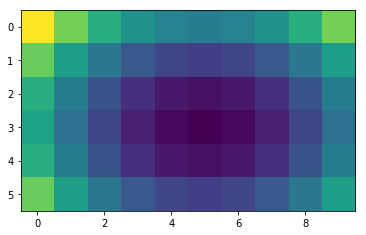

In [26]:
plt.imshow(F)

We can use this to evaluate any 2D function $f(x,y)$ over a 2D grid.

$$
f(x,y) = \begin{cases}
e^{\frac{(x+0.5)^2+y^2}{10}} - e^{(x+0.5)^2+y^2} \quad \text{for}\ y>0 \\
e^{\frac{(x-0.5)^2+y^2}{10}} - e^{(x-0.5)^2+y^2} \quad \text{for}\ y<0
\end{cases}
$$


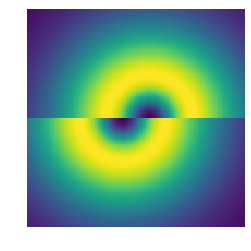

In [24]:
# 100 points from -4 to 4
x = np.linspace(-4, 4, 100)
y = np.linspace(-4, 4, 100)
# generate our grid
mx, my = np.meshgrid(x, y)

# implement the branch
step_mx = np.where(my < 0, mx - 0.5, mx + 0.5)

# a ring like function (difference of Gaussians)
fx = np.exp(-(step_mx**2 + my**2) / 10) - np.exp(-(step_mx**2 + my**2))
plt.imshow(fx)
plt.axis("off")

# Resources for this lecture
* **From Python to Numpy** http://www.labri.fr/perso/nrougier/from-python-to-numpy/ *recommended reading*

---

* **Floating point numbers** http://pmihaylov.com/floating-point-numbers/ (floats)
* **What Every Computer Scientist Should Know About Floating Point Numbers** http://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html

## Advanced (beyond this course)
* **Advanced NumPy** http://www.scipy-lectures.org/advanced/advanced_numpy/
* **NumPy tricks** http://arogozhnikov.github.io/2015/09/30/NumpyTipsAndTricks2.html and http://arogozhnikov.github.io/2015/09/29/NumpyTipsAndTricks1.html